In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('../input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Note:

* From the table above, we can drop id column as it has no impact on our model.
* The outcome variable is the final column "Stroke", we will drop it later and assign it as the target y.

In [ ]:
# Check the data shape
df.shape

(5110, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


* bmi has 201 missing values.
* Think about how to deal with bmi missing value later? dropna values? or fill them with the mean bmi based on gender?

In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Note: 
* age: why minimum value is 0.08? is it possible that missing value which is filled with 0 or 0.08? I will check it later.
* hypertension & heart disease: they are binary classification, not numerical result.


## Exploratory Data Analysis¶
* Check whether the data is balanced.
* Check the correlation between various features and stroke.

<AxesSubplot:ylabel='stroke'>

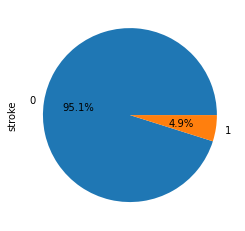

In [ ]:
# Check the data is balanced.
# Assign Stroke feature as the target y.
y = df["stroke"]
# Check y distribution
import matplotlib.pyplot as plt
import seaborn as sns
# sns.countplot(y)
y.value_counts().plot(kind='pie', autopct='%1.1f%%')

* It only has about 5% stroke in this dataset. This means ourdata is imbalanced, so we will do SMOTE to make the balanced data.

## Categorical Features
First of all, I select categorical features and show its relation with stroke.
* method: groupby, barplot


In [ ]:
# Select categorical features
cat_features = df.select_dtypes(include=['object']).columns
print(cat_features)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


In [ ]:
# gender vs. stroke
# method 1: groupby
df[['gender', 'stroke']].groupby('gender').mean().sort_values(by = 'stroke', ascending=False)

# method 2: groupby + barplot visualization
# fig = plt.figure(figsize=(6,4))
# ax = fig.gca()
# df.groupby('gender')[['stroke']].mean().sort_values(
#     by = 'stroke', ascending=False).plot.bar(stacked=False, ax=ax)
# ax.set_title('Stroke sorted by Gender')

,stroke
gender,
Male,0.051064
Female,0.047094
Other,0.000000


* From the result, we conclude that stroke raito in male and female is almost equal.

In [ ]:
# gender vs. ever_married
df[['ever_married', 'stroke']].groupby('ever_married').mean().sort_values(by='stroke', ascending=False)

,stroke
ever_married,
Yes,0.065613
No,0.016505


* Umm...It's interesting that people in marriage may have high ratio to get stroke.

In [ ]:
# gender vs. residence type
df[['Residence_type', 'stroke']].groupby('Residence_type').mean().sort_values(by='stroke', ascending=False)

,stroke
Residence_type,
Urban,0.052003
Rural,0.045346


* From the result above, it seems that no difference in residence_type.

Text(0.5, 1.0, 'Stroke sorted by work_type')

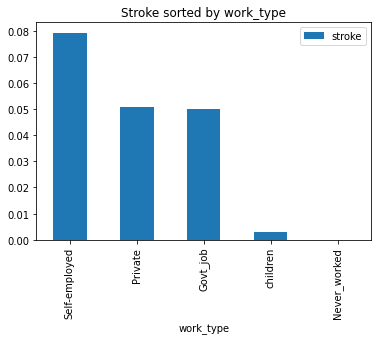

In [ ]:
# work_type vs. stroke
# method 1: groupby
# df[['work_type', 'stroke']].groupby('work_type').mean().sort_values(by='stroke', ascending=False)

# method 2: groupby + barplot 
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
df.groupby('work_type')[['stroke']].mean().sort_values(
    by = 'stroke', ascending=False).plot.bar(stacked=False, ax=ax)
ax.set_title('Stroke sorted by work_type')

* It shows that people work in private companies have relative high ratio of stroke, while children and never_worked people have less or no stroke. Perhaps working pressure is one of the cause to induce stroke.

Text(0.5, 1.0, 'Stroke sorted by smoking_status')

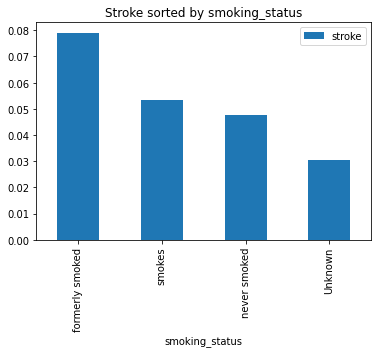

In [ ]:
# smokig_status vs. smoking_status
# method 1: groupby
# df[['smoking_status', 'stroke']].groupby('smoking_status').mean().sort_values(by='stroke', ascending=False)

# method 2: groupby + barplot 
fig = plt.figure(figsize=(6,4))
ax = fig.gca()
df.groupby('smoking_status')[['stroke']].mean().sort_values(
    by = 'stroke', ascending=False).plot.bar(stacked=False, ax=ax)
ax.set_title('Stroke sorted by smoking_status')

* Smoking maybe a risky factor to get stroke.

#### Hypertension and heart_disease are binary classification, so I use "groupby" to present the stroke ratio here.

In [ ]:
# heart_disease vs. smoking_status
df[['heart_disease', 'stroke']].groupby('heart_disease').mean().sort_values(by='stroke', ascending=False)

,stroke
heart_disease,
1,0.170290
0,0.041787


In [ ]:
# hypertension vs. stroke
df[['hypertension', 'stroke']].groupby('hypertension').mean().sort_values(by='stroke', ascending=False)

,stroke
hypertension,
1,0.132530
0,0.039679


* From the results above, people with hypertension and heart_disease have high potential to get stroke.

### Numerical features

In [ ]:
df.select_dtypes(exclude=['object']).columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke'],
      dtype='object')

* For numerical features, I only explor age, avg_glucose_level, and bmi as others I have addressed earlier.

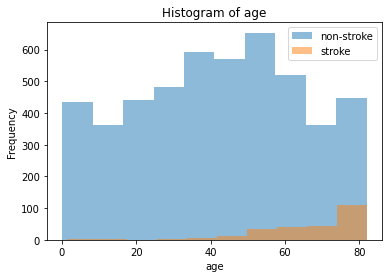

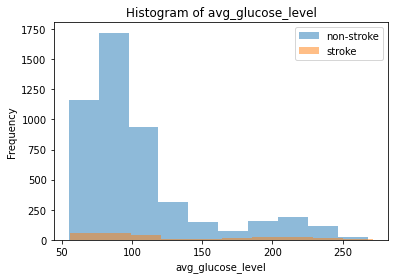

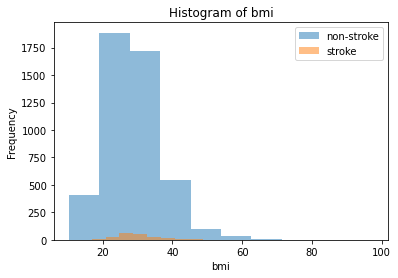

In [ ]:
for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.hist(df[df['stroke']==0][col], 10, alpha=0.5, label='non-stroke')
    plt.hist(df[df['stroke']==1][col], 10, alpha=0.5, label='stroke')
    plt.legend(loc='upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(col))
    plt.show()

From the 3 plots above:
* Older people are more likely to experience stroke.
* Although most literatures indicated that avg_glucose_level and bmi are important factors to induce stroke, the plots above seems not show the significant impacts on stroke here. I will use correlation map to check it later.

### Data Preprocessing
* Label-encoding and One-hot encoding
* Minimum age: 0.08 or 0?
* Dealing with missing values: bmi
* scaling features

In [ ]:
#Converting Categorical Data to LabelEncoding and One-hot encoding
# Label encoding (mapping): gender, ever_married, Residence_type
df["gender"] = df["gender"].map({"Male":0, "Female":1, "Other":2})
df["ever_married"] = df["ever_married"].map({"No":0, "Yes":1})
df["Residence_type"] = df["Residence_type"].map({"Urban":0, "Rural":1})

# One-hot encoding: smoking_status, work_type
df = pd.get_dummies(data=df, columns=['smoking_status'])
df = pd.get_dummies(data=df, columns=['work_type'])
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,0,67.0,0,1,1,0,228.69,36.6,1,0,1,0,0,0,0,1,0,0
1,51676,1,61.0,0,0,1,1,202.21,NaN,1,0,0,1,0,0,0,0,1,0
2,31112,0,80.0,0,1,1,1,105.92,32.5,1,0,0,1,0,0,0,1,0,0
3,60182,1,49.0,0,0,1,0,171.23,34.4,1,0,0,0,1,0,0,1,0,0
4,1665,1,79.0,1,0,1,1,174.12,24.0,1,0,0,1,0,0,0,0,1,0


* #### Find out minimum age? 0.08?

In [ ]:
# Age: find out which row, and think about male/female? estimate his/her age.
df[df['age']==0.08]

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
1614,47350,1,0.08,0,0,0,0,139.67,14.1,0,1,0,0,0,0,0,0,0,1
3295,29955,0,0.08,0,0,0,1,70.33,16.9,0,1,0,0,0,0,0,0,0,1


* I found out 2 rows that its age was filled with 0.08. It might be missing value that filled with 0 or 0.08. Anyway, I will correct the value based on its gender and fill it with mean age.

In [ ]:
# correct male age
male_mean_age = df[df['gender'] == 1]['age'].mean()
df.iloc[1614, 2] = round(male_mean_age, 1)

# correct female age
female_mean_age = df[df['gender'] == 0]['age'].mean()
df.iloc[3295, 2] = round(female_mean_age, 1)


* #### Dealing with missing value: bmi
Becasue bmi has 201 missing value, it is relative low ratio in the dataset. I will dropna first, and see what happened after dropna in bmi columns.

In [ ]:
# drop the rows with missing values
df_dropped = df.dropna()
print("retained {}% of rows".format(round(100*(df.shape[0] - df_dropped.shape[0])/float(df.shape[0]))))


retained 4% of rows


#### some EDA of the dataset before it was dropped and after

In [ ]:
# before dropped 
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [ ]:
# after dropped
df_dropped['stroke'].value_counts(normalize=True)

# the results are relatively the same

0    0.957425
1    0.042575
Name: stroke, dtype: float64

* No significant changes in stroke/non-stroke after dropping na values. So I use df_dropped dataset for following data preprocessing.

#### Scaling the features: age, avg_glucose_level, bmi

In [ ]:
from sklearn.preprocessing import StandardScaler
std=StandardScaler()
columns = ['age', 'avg_glucose_level','bmi']
scaled = std.fit_transform(df[['age', 'avg_glucose_level','bmi']])
scaled = pd.DataFrame(scaled,columns=columns)
df_dropped=df_dropped.drop(columns=columns,axis=1)

In [ ]:
df_dropped=df_dropped.merge(scaled, left_index=True, right_index=True, how = "left")
df_dropped.head()

,id,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,age,avg_glucose_level,bmi
0,9046,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1.051438,2.706375,0.981345
2,31112,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1.626804,-0.005028,0.459269
3,60182,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0.254778,1.437358,0.701207
4,1665,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,1.582545,1.501184,-0.623083
5,56669,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1.671063,1.768195,0.013595


In [ ]:
# drop id
df_dropped=df_dropped.drop(columns='id',axis=1)
df_dropped.head()


,gender,hypertension,heart_disease,ever_married,Residence_type,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,age,avg_glucose_level,bmi
0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1.051438,2.706375,0.981345
2,0,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1.626804,-0.005028,0.459269
3,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0.254778,1.437358,0.701207
4,1,1,0,1,1,1,0,0,1,0,0,0,0,1,0,1.582545,1.501184,-0.623083
5,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1.671063,1.768195,0.013595


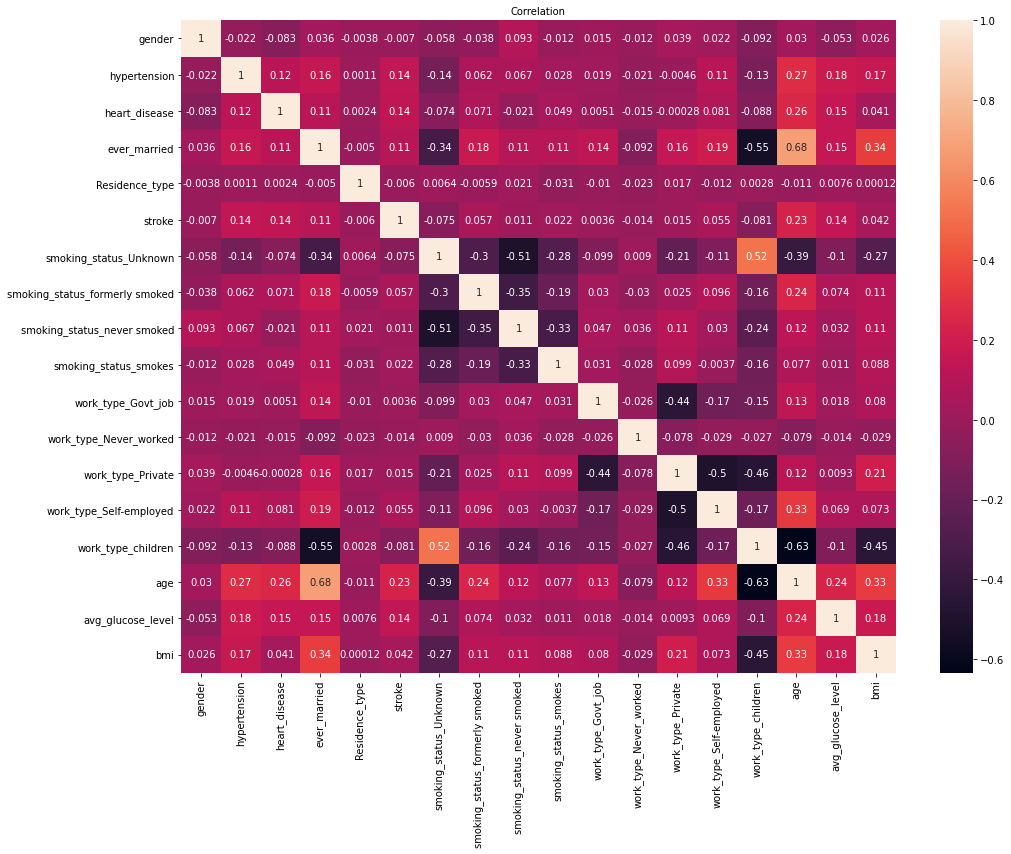

In [ ]:
# look at the heatmap of the correlation matrix of our dataset
correlation = df_dropped.corr()

fig, ax = plt.subplots(figsize= (16, 12))
plt.title("Correlation", size=10)
sns.heatmap(correlation, annot=True)
plt.show()

In [ ]:
correlation["stroke"].sort_values(ascending=False).head(10)

stroke                            1.000000
age                               0.232337
hypertension                      0.142515
avg_glucose_level                 0.138936
heart_disease                     0.137938
ever_married                      0.105089
smoking_status_formerly smoked    0.057320
work_type_Self-employed           0.055356
bmi                               0.042374
smoking_status_smokes             0.021530
Name: stroke, dtype: float64

* The first three, Age, heart_disease and avg_glucose_level, have high correlation with stroke.

# Classification Models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.model_selection import train_test_split
X = df_dropped.drop(['stroke'], axis=1).values 
y = df_dropped['stroke'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

#### Logistic Regression

In [ ]:
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred)
cm_lr = confusion_matrix(y_test,y_pred)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Logistic Regression: ")
print("accuracy score: \n", acc_lr)
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("confusion matrix: \n", cm_lr)

Logistic Regression: 
accuracy score: 
 0.9562118126272913
K-Fold Validation Mean Accuracy: 95.80 %
confusion matrix: 
 [[939   0]
 [ 43   0]]


#### SVM

In [ ]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_svc = accuracy_score(y_test, y_pred)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
cm_svc = confusion_matrix(y_test,y_pred)
print("SVM: ")
print("accuracy score: \n", acc_svc)
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("confusion matrix: \n", cm_svc)

SVM: 
accuracy score: 
 0.9562118126272913
K-Fold Validation Mean Accuracy: 95.77 %
confusion matrix: 
 [[939   0]
 [ 43   0]]


#### KNN

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
cm_knn = confusion_matrix(y_test, y_pred)
print("KNN: ")
print("knn accuracy: \n", acc_knn)
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("knn confusion matrix: \n", cm_knn)

KNN: 
knn accuracy: 
 0.9541751527494908
K-Fold Validation Mean Accuracy: 95.59 %
knn confusion matrix: 
 [[936   3]
 [ 42   1]]


#### Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators = 100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_rfc = accuracy_score(y_test, y_pred)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
cm_rfc = confusion_matrix(y_test, y_pred)
print("Random Forest Classifier:")
print("accuracy score: \n", acc_rfc)
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("confusion matrix: \n", cm_rfc)

Random Forest Classifier:
accuracy score: 
 0.9562118126272913
K-Fold Validation Mean Accuracy: 95.67 %
confusion matrix: 
 [[939   0]
 [ 43   0]]


#### XGBoost

In [ ]:
model = XGBClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred)
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
cm_xgb = confusion_matrix(y_test, y_pred)
print("XGBoost:")
print("accuracy score: \n", acc_xgb)
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("confusion matrix: \n", cm_xgb)

[07:40:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:40:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:40:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:40:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

### Tuning the model

In [ ]:
from sklearn.model_selection import GridSearchCV

X_dropped = df_dropped.drop('stroke', axis=1)
y_dropped = df_dropped['stroke']


lr_params = {'C':[0.25,0.5,0.75,1]}

lr = LogisticRegression()
grid = GridSearchCV(lr, lr_params)
grid.fit(X_dropped, y_dropped)
print(grid.best_score_, grid.best_params_)

0.9576291701181926 {'C': 0.5}
